# Esercitazione 4

## 10000 Simulazioni

In [1]:
import numpy as np

In [2]:
def mmq(matrix):
    S00 = np.float32(0)
    S01 = np.float32(0)
    S10 = np.float32(0)
    S11 = np.float32(0)
    S20 = np.float32(0)

    S00 = sum(1.0/(matrix[:,2])**2)
    S01 = sum((matrix[:,1]/(matrix[:,2])**2))
    S10 = sum(matrix[:,0]/(matrix[:,2])**2)
    S11 = sum(matrix[:,0]*matrix[:,1]/(matrix[:,2])**2)
    S20 = sum((matrix[:,0]/(matrix[:,2]))**2)

    D = S00*S20 - S10**2
    m = (S00*S11 - S10*S01)/D
    q = (S01*S20 - S11*S10)/D
    stdm = np.sqrt(S00/D)
    stdq = np.sqrt(S20/D)
    cov = -(S10)/D
    cor = cov/(stdm * stdq)

    return (m, stdm, q, stdq, cor)

In [3]:
from scipy.special import gamma
from scipy.integrate import trapezoid

# Finds the critical zone of the chi_n^2 test by bisection
def findCriticalZone(alpha, n):

    probability = np.float64(0)
    steps = 1000

    marginOfError = 0.00001
    lower = 1.0 - alpha - marginOfError
    upper = 1.0 - alpha + marginOfError

    x_0 = np.float64(0)
    inf = np.float64(0)     # inteval used in bisection
    sup = np.float64(10*n)  
    x = np.float64(10*n)    # output variable

    chi_n = lambda y : (np.pow(y, (n/2.0 - 1))*np.exp(-y/2.0))/(np.pow(2.0, n/2.0) * gamma(n/2.0))
    
    for iterations in range (100):
        points = np.linspace(x_0, x, num=steps)
    
        # Probability
        probability = trapezoid(chi_n(points), points)


        # if iterations%10 == 0:
        #     print(f"{iterations} \t Probability = {probability} \t x = {x} \t [{inf}, {sup}]")

        if ( (probability >= lower) and (probability <= upper) ):
            return x
        elif (probability >= upper):
            sup = x
            x = (sup + inf)/2
        else:
            inf = x
            x = (sup + inf)/2


In [4]:
# Chi_2 Test
def chi2test(y, yexpected, stdy, t_alpha):

    t = sum((y - yexpected)**2/ stdy**2 )
    ndf = np.size(y)        # Change ndf based on the number of relations between the data

    isCompatible = np.bool(t <= t_alpha)

    chi_n = lambda y : (np.pow(y, (ndf/2.0 - 1))*np.exp(-y/2.0))/(np.pow(2.0, ndf/2.0) * gamma(ndf/2.0))
    points = np.linspace(0, t, num=1000)
    p = 1 - trapezoid(chi_n(points), points)


    return isCompatible, t/ndf, p

In [5]:
data = np.empty(shape = (7, 3), dtype = np.float32)
data[:, 0] = (0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0)
data[:, 2] = (2.3, 2.2, 4.8, 4.5, 10.5, 10.1, 10.2)

simulations = open("simulations.txt", "w")
num_points = 10000

# Hypothesis test
alpha = np.float32(0.05)
ndf = 7
t_alpha = findCriticalZone(alpha, ndf)
print(f"Critical Zone: >= {t_alpha:.3f}")
testResults = open("testResults.txt", "w")

m_0 = np.float32(20)
q_0 = np.float32(0)
hypothesis = lambda x : m_0 * x + q_0



for i in range(0, num_points):
    data[:, 1] = m_0 * data[:,0] +  np.random.normal(q_0, data[:, 2])

    # MMQ Parameters estimate
    mmq_values = np.array(mmq(data))
    simulations.write(" ".join(map(str, mmq_values)))
    simulations.write("\n")

    # Chi2 test
    test = np.array(chi2test(y = data[:,1], yexpected = hypothesis(data[:,0]), stdy = data[:,2], t_alpha = t_alpha))
    testResults.write(" ".join(map(str, test)))
    testResults.write("\n")


simulations.close()
testResults.close()


Critical Zone: >= 14.067


## Istogrammi

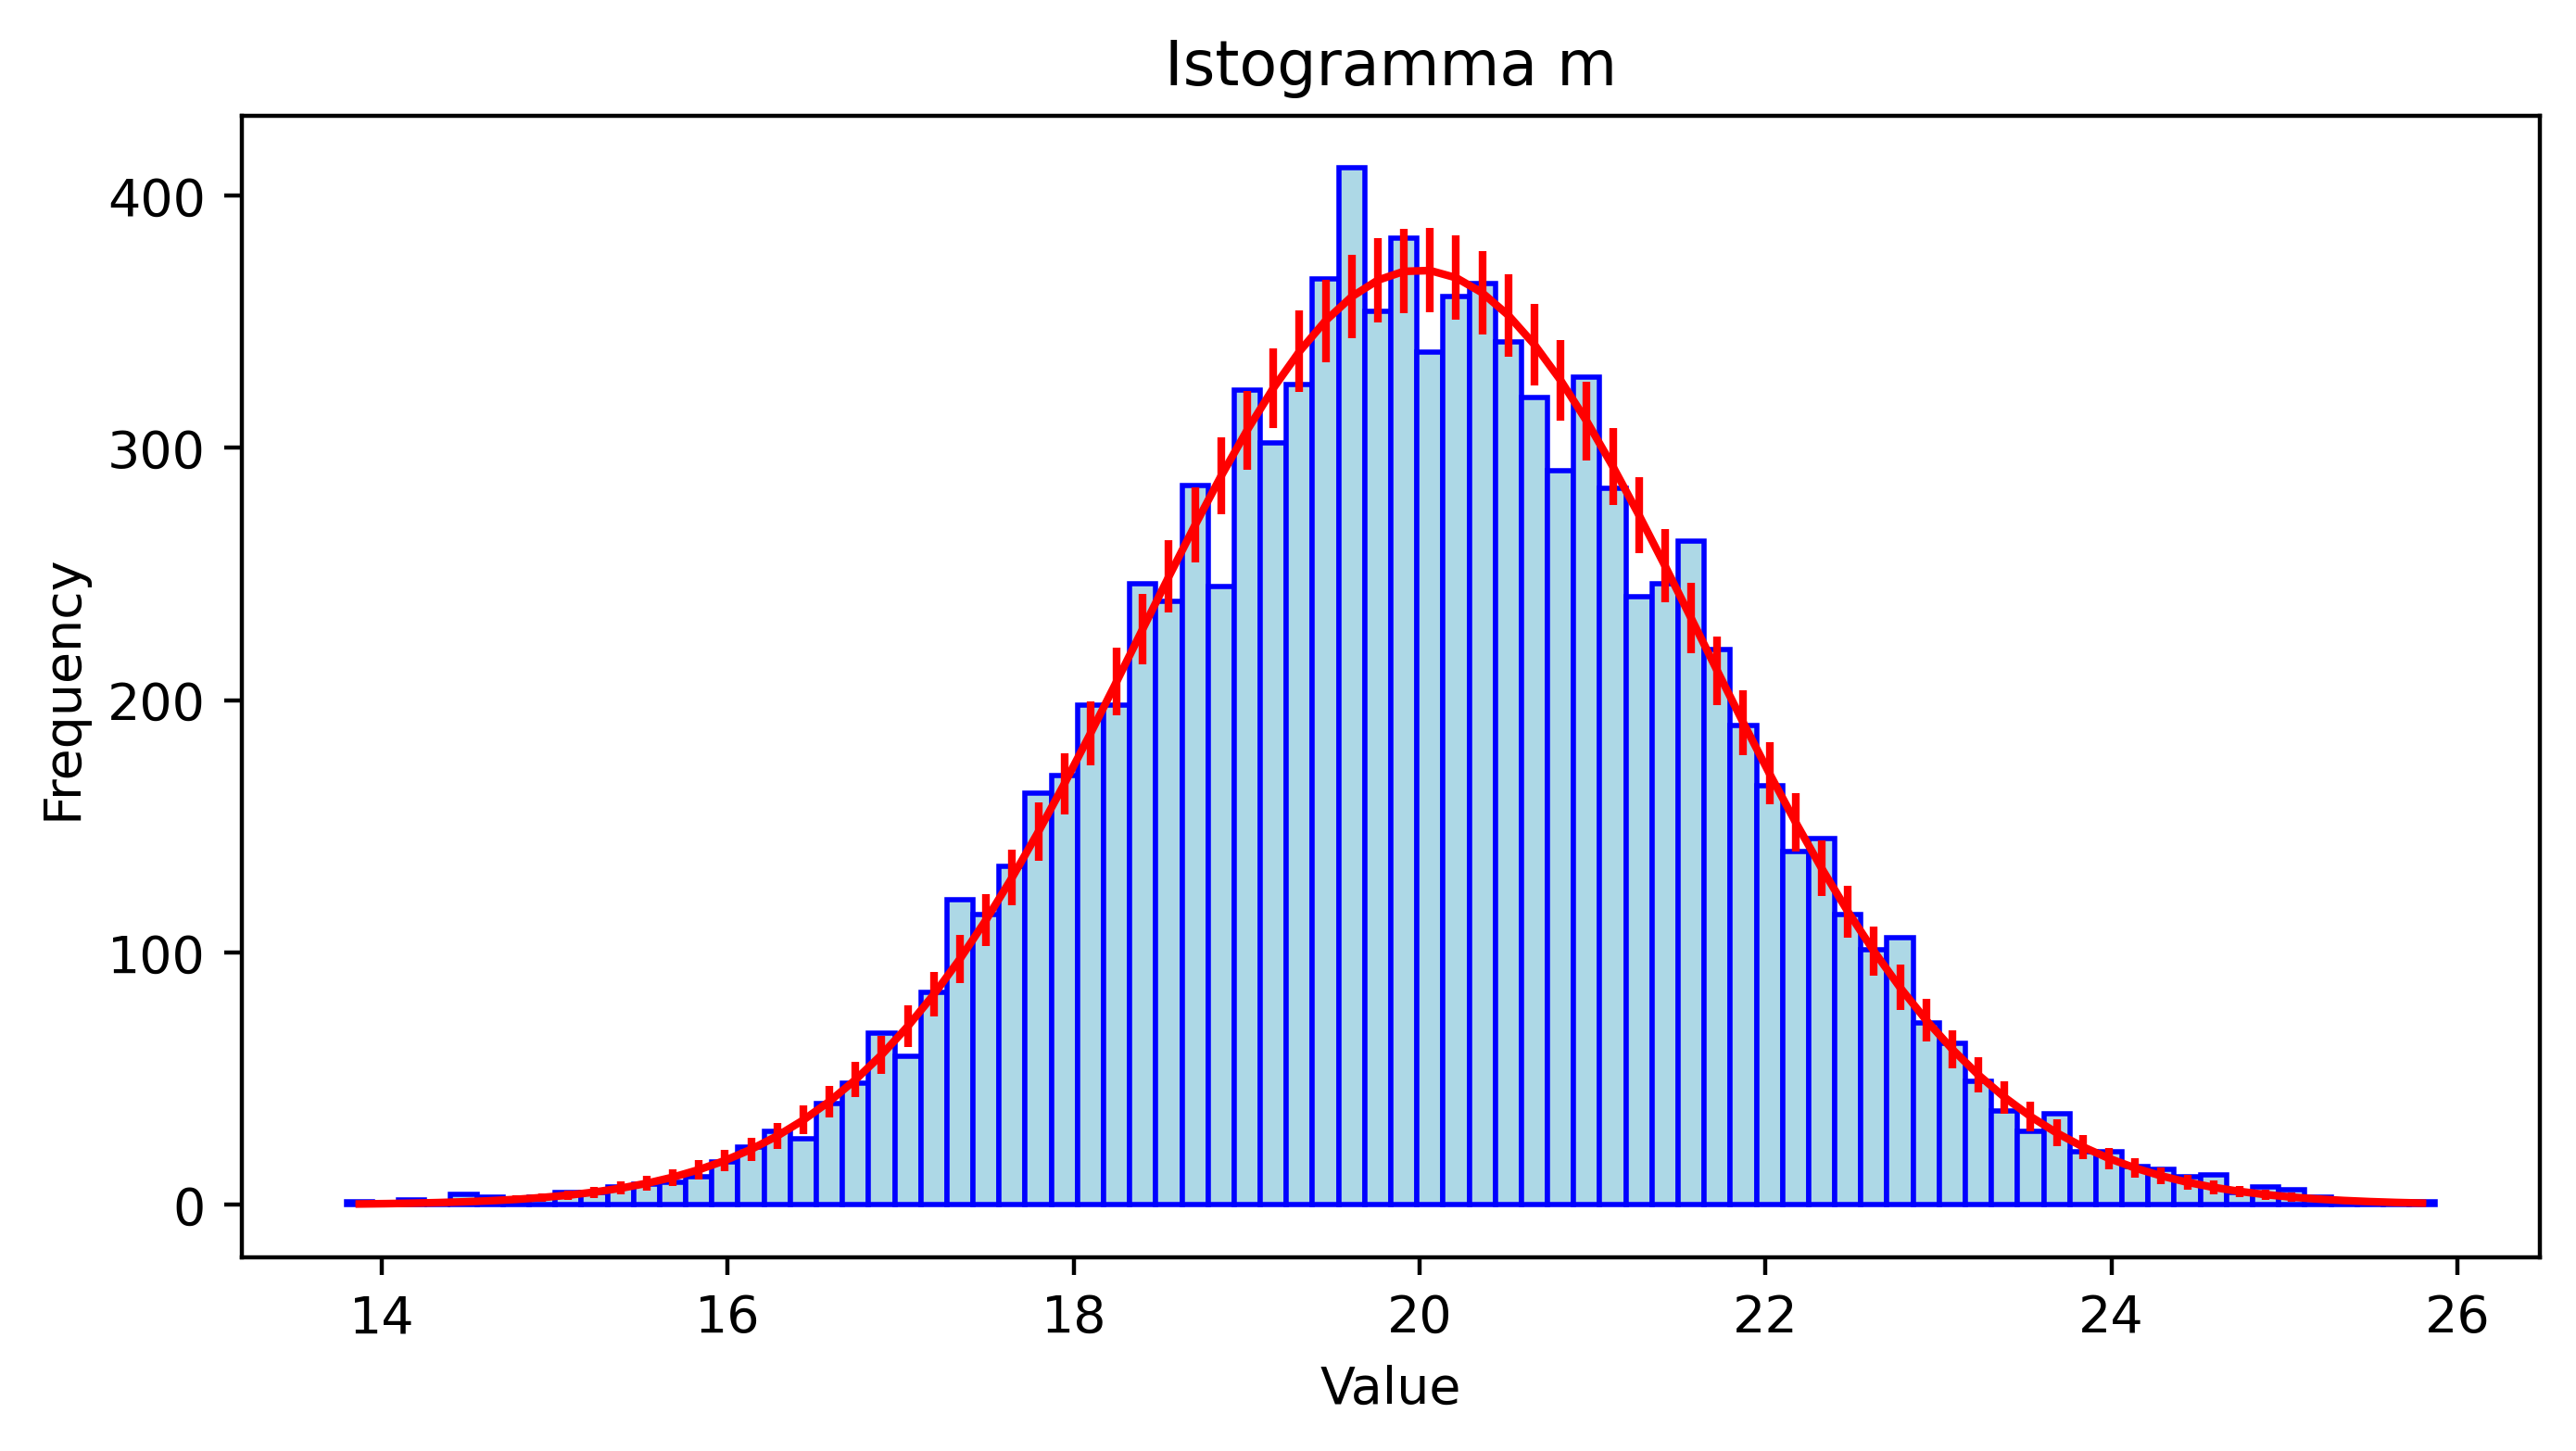

In [6]:
# Histogram m

points = np.genfromtxt("simulations.txt", delimiter=" ")

import matplotlib.pyplot as plt

stdm = mmq_values[1]
min_value = np.min(points[:,0]) 
max_value = np.max(points[:,0])
nbins = 80
interval = (max_value - min_value)/nbins


gaussm = lambda x : np.exp(-(x - 20)**2/(2*stdm**2))/(np.sqrt(2* np.pi) * stdm)
xpoints = np.linspace(min_value + interval/2, max_value - interval/2, num=nbins )
ypoints = gaussm(xpoints)*interval*num_points
y_err = np.sqrt(ypoints*(1 - gaussm(xpoints)))

# Create a histogram
plt.figure(figsize=(8, 4), dpi=400)
plt.hist(points[:,0], bins=80, color='lightblue', edgecolor='blue')
plt.errorbar(xpoints, ypoints, yerr = y_err, color = 'red')

# Label the axes
plt.xlabel('Value')
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Istogramma m')

# Display the plot

plt.show()
plt.close()


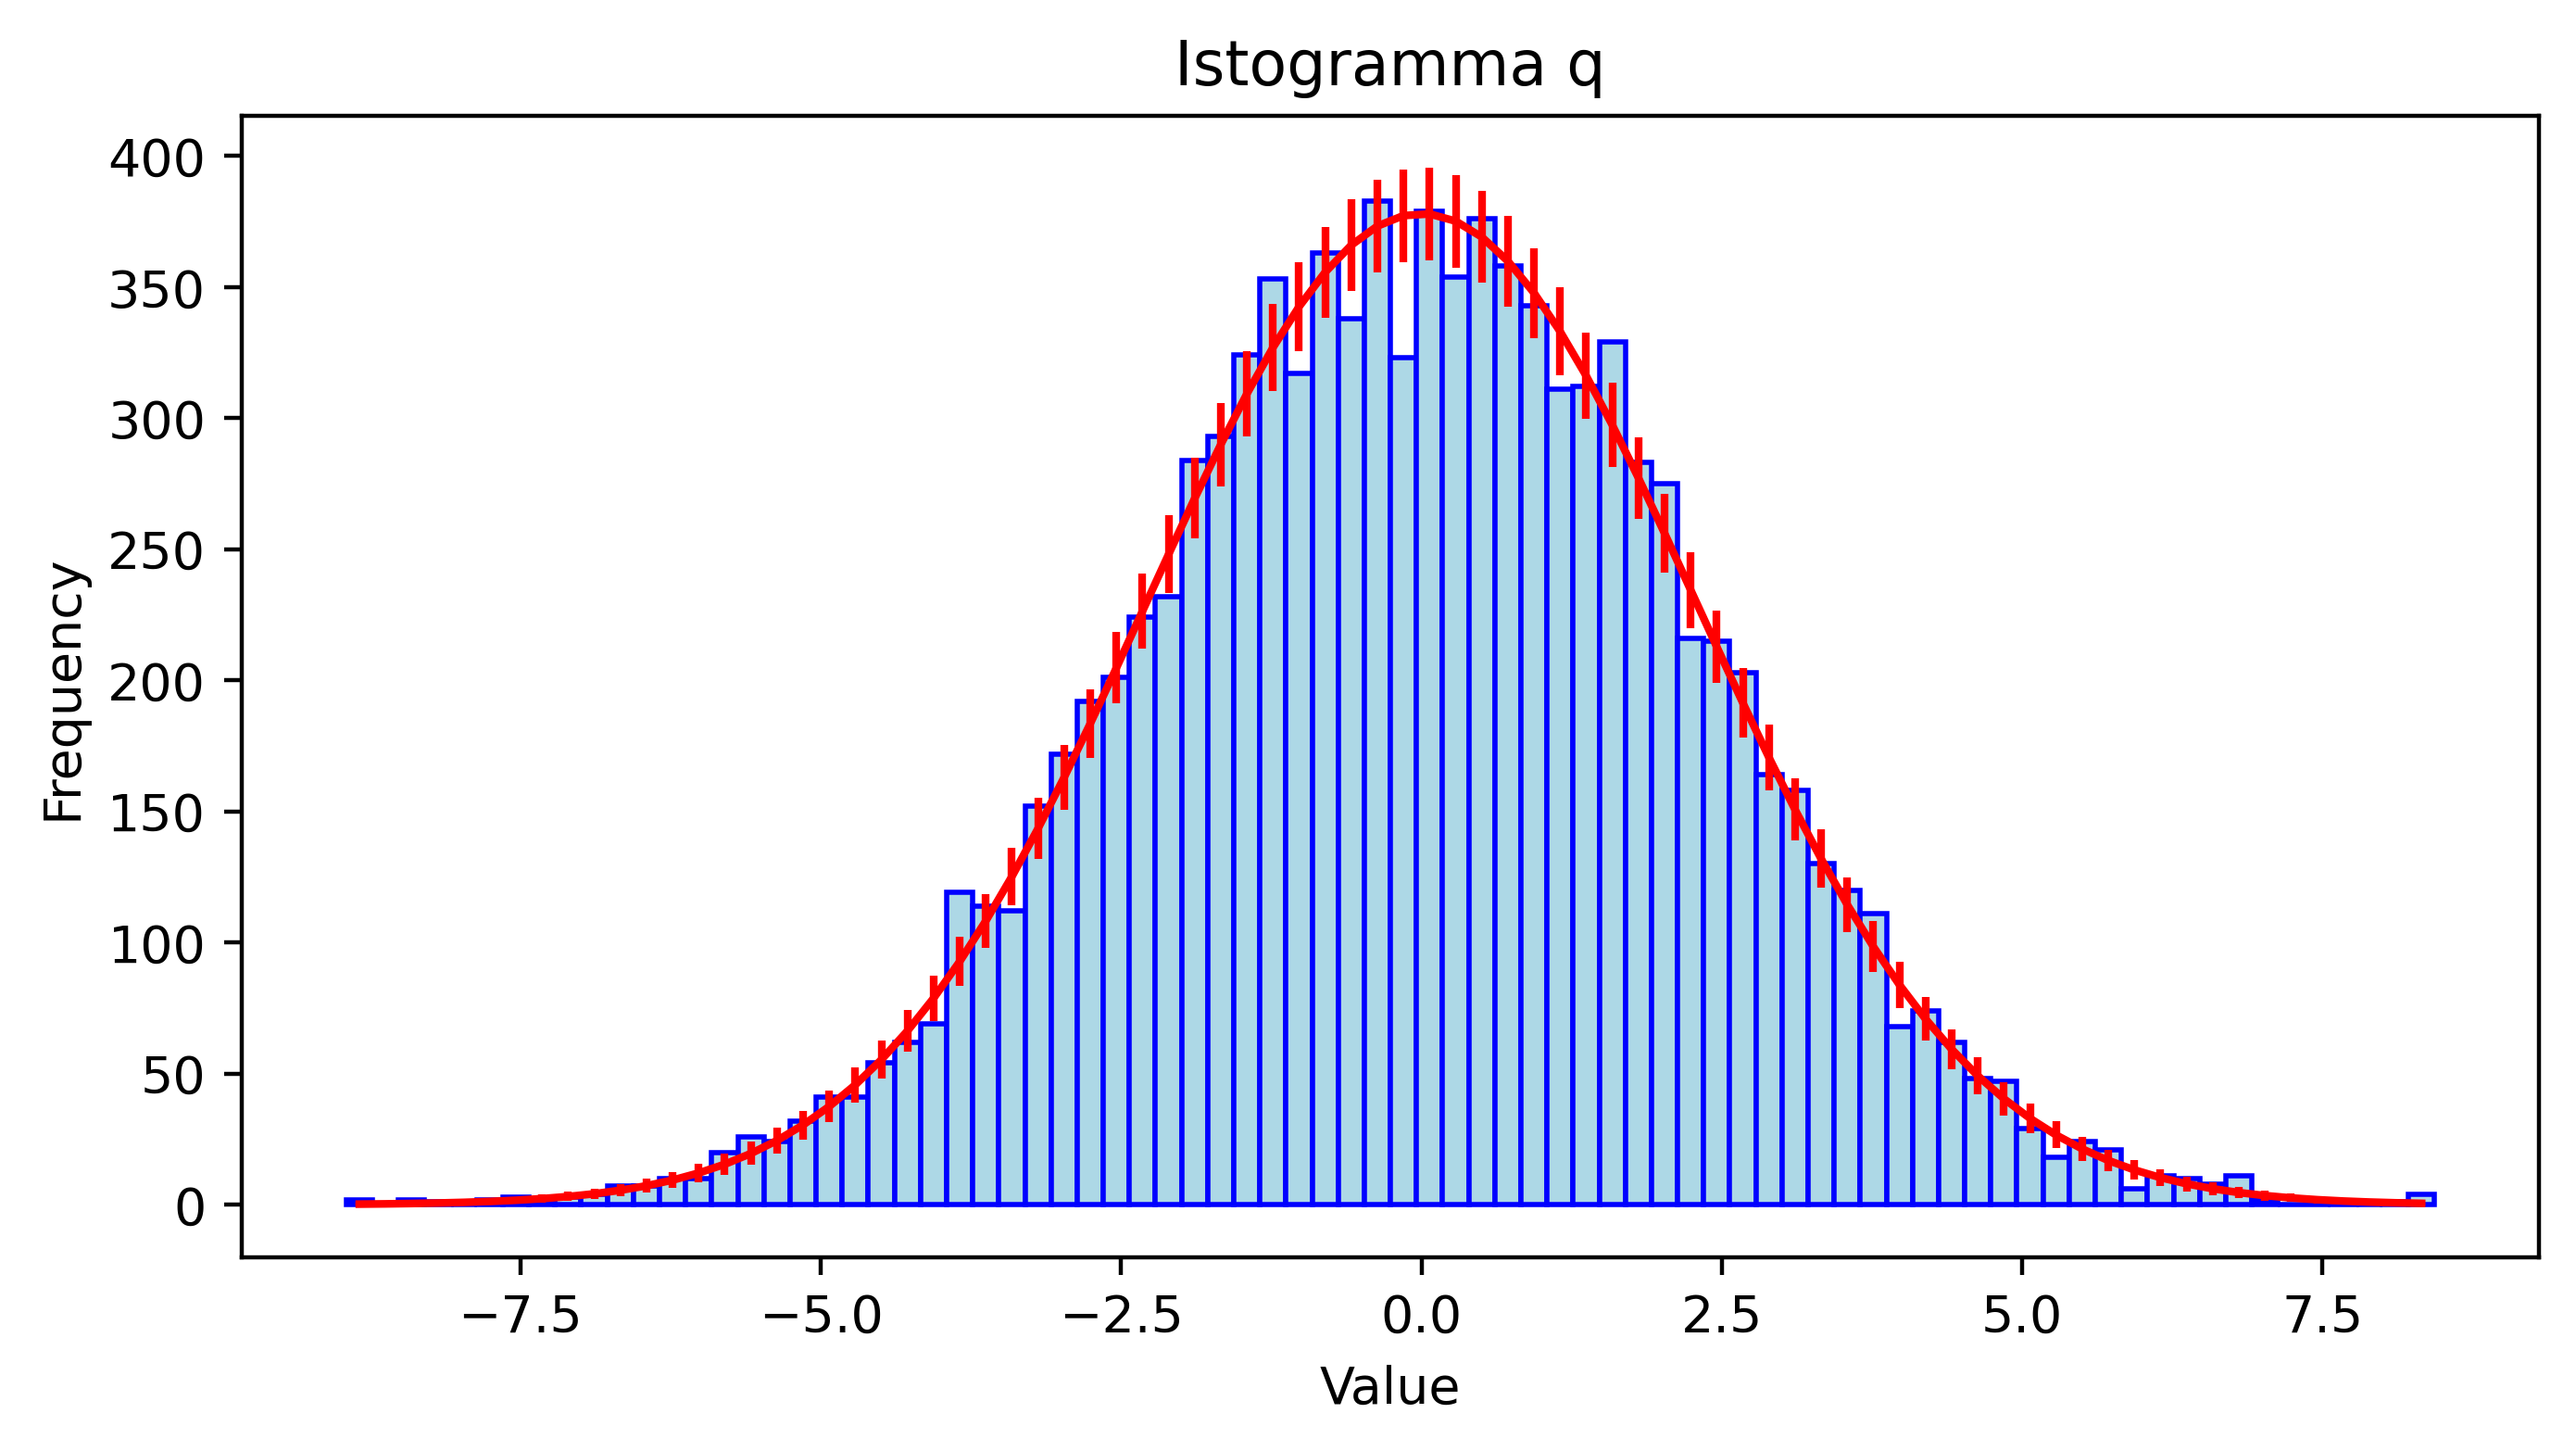

In [7]:
# Histogram q

stdq = mmq_values[3]
min_value = np.min(points[:,2]) 
max_value = np.max(points[:,2])
nbins = 80
interval = (max_value - min_value)/nbins


gaussq = lambda x : np.exp(-(x)**2/(2*stdq**2))/(np.sqrt(2* np.pi) * stdq)
xpoints = np.linspace(min_value + interval/2, max_value - interval/2, num=nbins)
ypoints = gaussq(xpoints)*interval*num_points
y_err = np.sqrt(ypoints*(1 - gaussq(xpoints)))

# Create a histogram
plt.figure(figsize=(8, 4), dpi=400)
plt.hist(points[:,2], bins=80, color='lightblue', edgecolor='blue')
plt.errorbar(xpoints, ypoints, yerr = y_err, color = 'red')

# Label the axes
plt.xlabel('Value')
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Istogramma q')

# Display the plot

plt.show()
plt.close()


## Grafico Bidimensionale (m, q)

10000


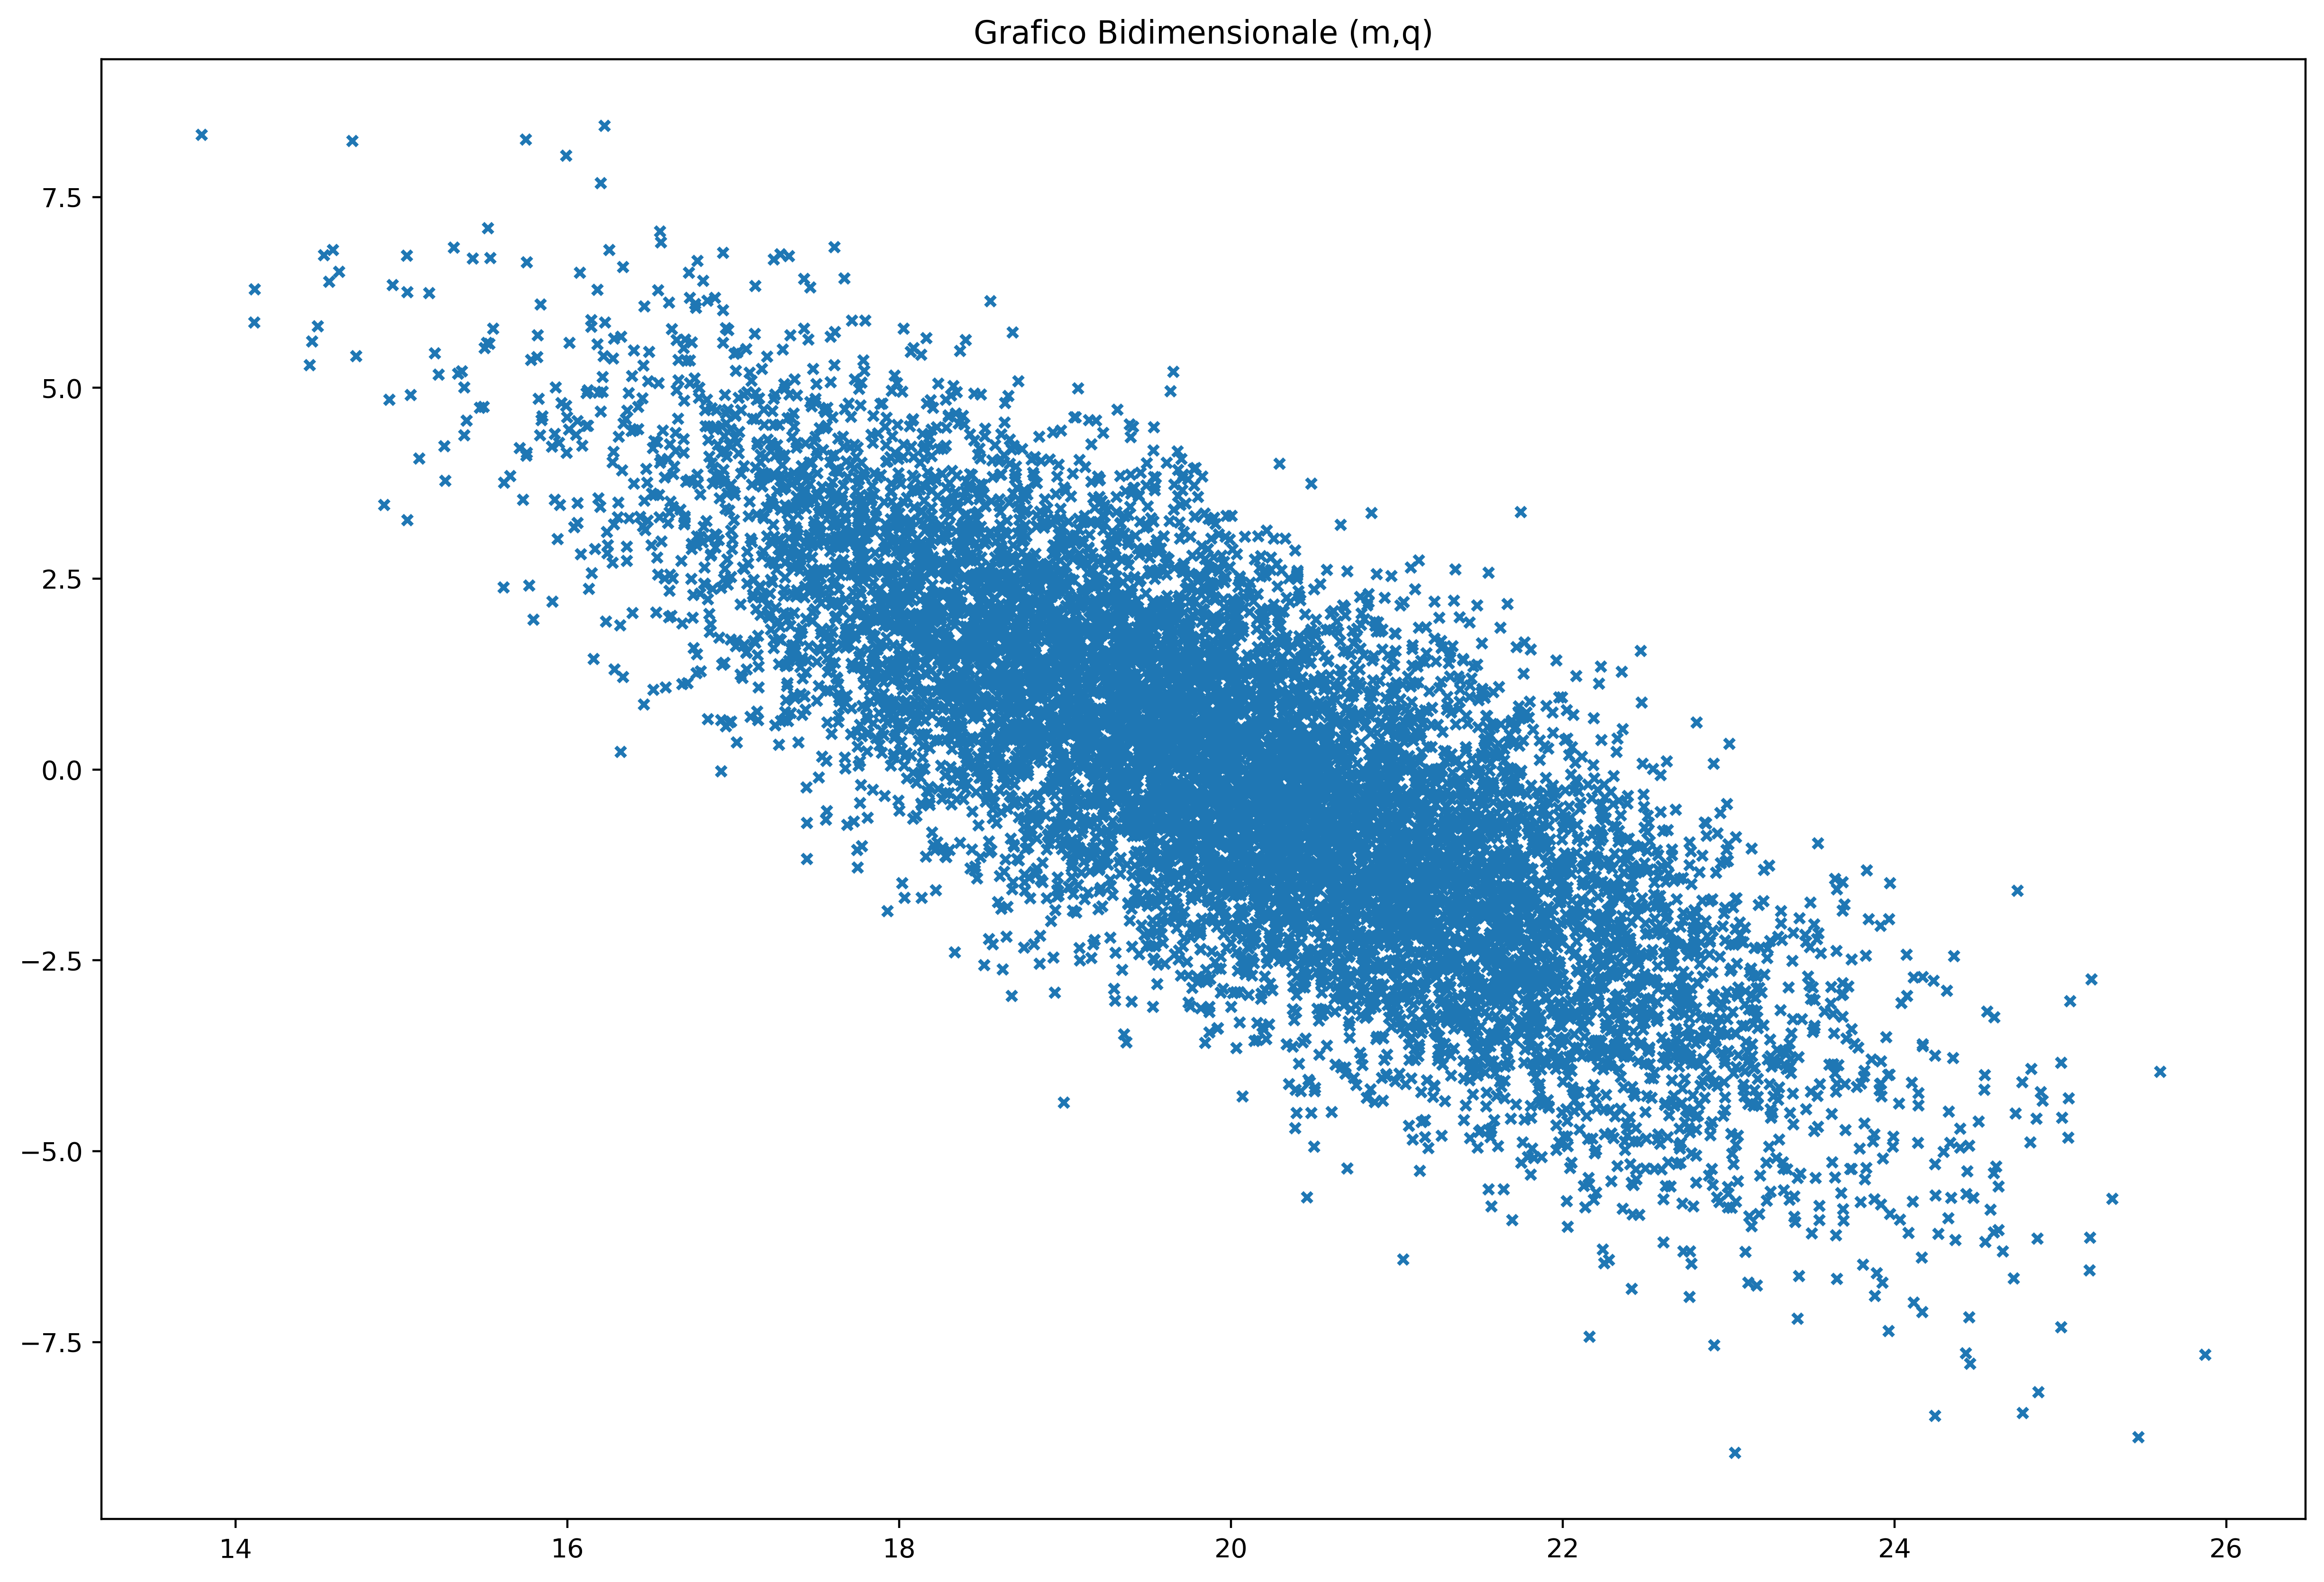

In [8]:
plt.figure(figsize=(15,10), dpi= 400)
plt.title('Grafico Bidimensionale (m,q)')

print(points[:,3].size)
plt.scatter(points[:,0], points[:,2], s=14, marker = 'x',)

plt.savefig("m-q.svg", format='svg')

In [9]:
def isInsideEllipse(x, y, x0, y0, sdx, sdy, cor, Q2):

    value = (((x - x0)/sdx)**2 - 2*cor*(x - x0)*(y - y0)/(sdx*sdy) + ((y-y0)/sdy)**2)/(1-cor**2) - Q2
    return value <= 0
    

In [10]:
cor = mmq_values[4]

x0 = m_0
y0 = q_0
c = 1

Q1inside =sum(isInsideEllipse(points[:,0], points[:,2], m_0, q_0, stdm, stdq, cor, c))

x0 = m_0
y0 = q_0
c = 4
Q4inside = sum(isInsideEllipse(points[:,0], points[:,2], m_0, q_0, stdm, stdq, cor, c))

x0 = np.float32(21.0)
y0 = np.float32(-2.0)
c = 1
Q1arbitrary = sum(isInsideEllipse(points[:,0], points[:,2], x0, y0, stdm, stdq, cor, c))

10000


/tmp/ipykernel_4742/2719614997.py:3: RuntimeWarning: invalid value encountered in sqrt
  y1 = lambda x : 1.0/2.0*(1.0 - cor**2.0)*stdq**2*(-np.sqrt((4*x0**2*cor**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (4.0*x0**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (8.0*x0*cor**2*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (8.0*x0*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (4.0*c)/((1.0 - cor**2)*stdq**2) + (4.0*cor**2*x**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (4.0*x**2)/((1.0 - cor**2)**2*stdm**2*stdq**2)) - (2.0*x0*cor)/((1.0 - cor**2)*stdm*stdq) + (2*y0)/((1.0 - cor**2)*stdq**2) + (2*cor*x)/((1.0 - cor**2)*stdm*stdq))
/tmp/ipykernel_4742/2719614997.py:5: RuntimeWarning: invalid value encountered in sqrt
  y2 = lambda x : 1.0/2.0*(1.0 - cor**2.0)*stdq**2*(np.sqrt((4*x0**2*cor**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (4.0*x0**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (8.0*x0*cor**2*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (8.0*x0*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (4.0*c)/((1.0 - cor**2)*stdq**

1.6260371 2.2928746 -0.79500026


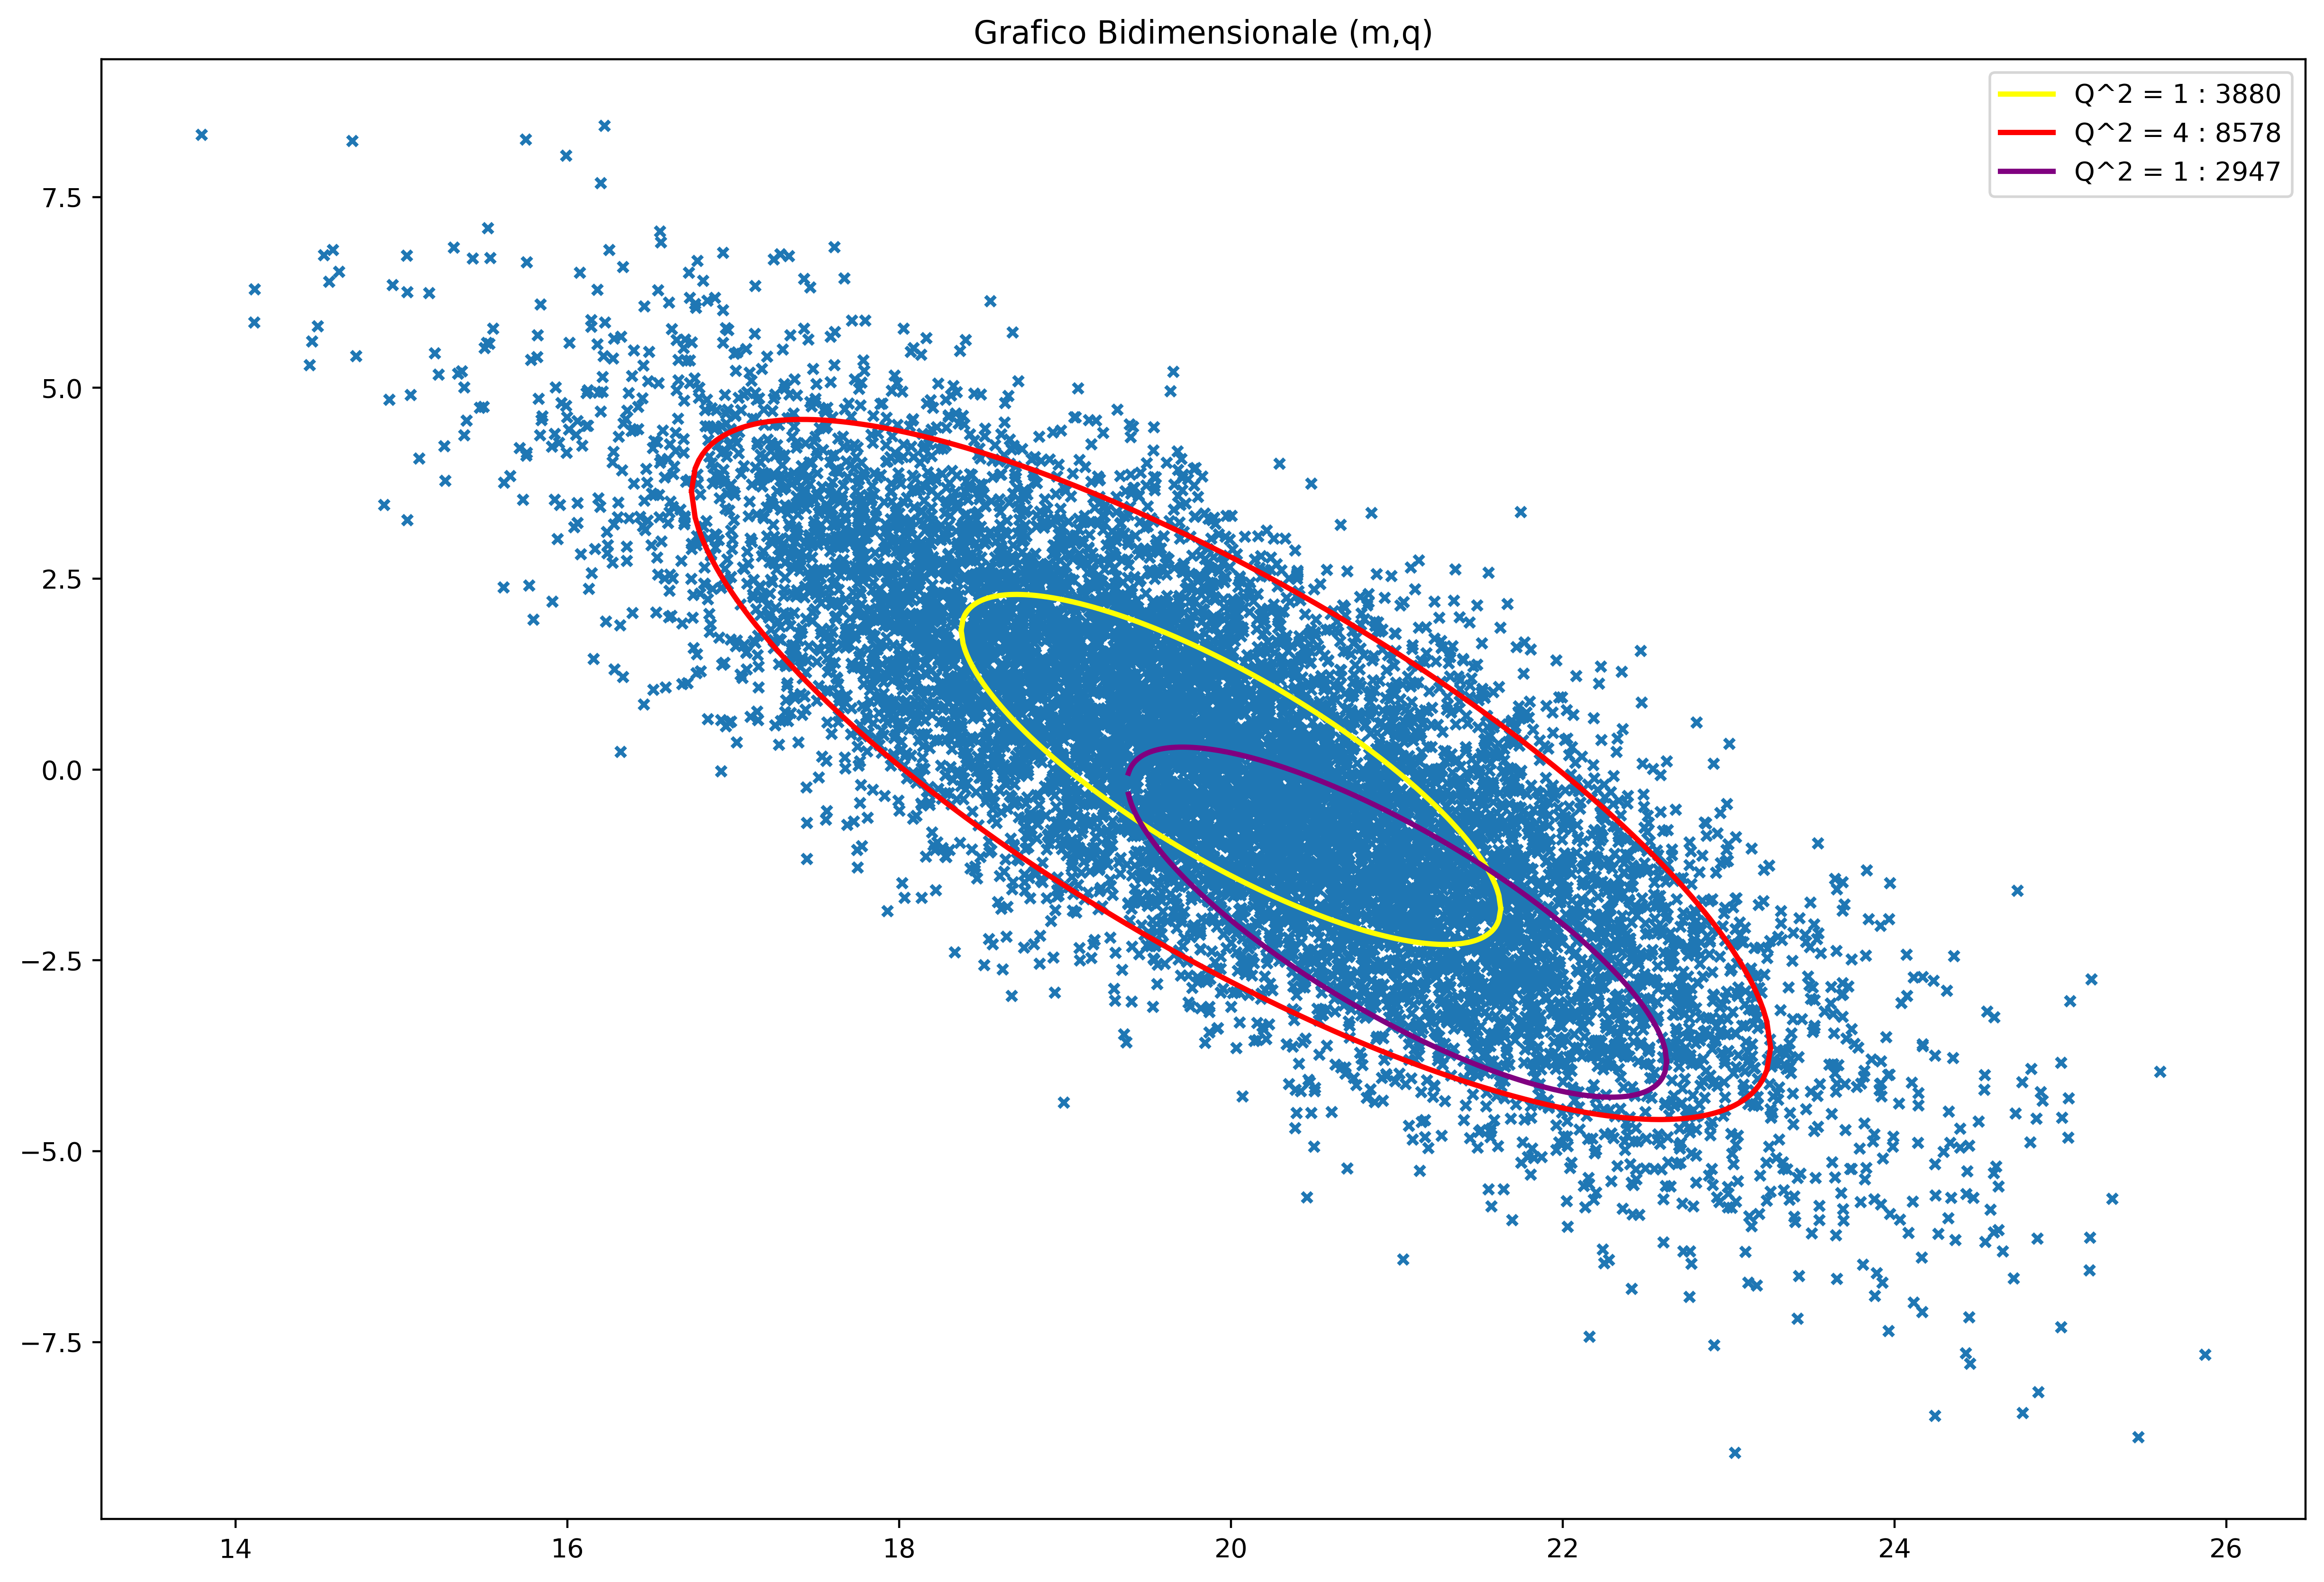

In [11]:
# Drawing the ellipses

y1 = lambda x : 1.0/2.0*(1.0 - cor**2.0)*stdq**2*(-np.sqrt((4*x0**2*cor**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (4.0*x0**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (8.0*x0*cor**2*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (8.0*x0*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (4.0*c)/((1.0 - cor**2)*stdq**2) + (4.0*cor**2*x**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (4.0*x**2)/((1.0 - cor**2)**2*stdm**2*stdq**2)) - (2.0*x0*cor)/((1.0 - cor**2)*stdm*stdq) + (2*y0)/((1.0 - cor**2)*stdq**2) + (2*cor*x)/((1.0 - cor**2)*stdm*stdq))

y2 = lambda x : 1.0/2.0*(1.0 - cor**2.0)*stdq**2*(np.sqrt((4*x0**2*cor**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (4.0*x0**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (8.0*x0*cor**2*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (8.0*x0*x)/((1.0 - cor**2)**2*stdm**2*stdq**2) + (4.0*c)/((1.0 - cor**2)*stdq**2) + (4.0*cor**2*x**2)/((1.0 - cor**2)**2*stdm**2*stdq**2) - (4.0*x**2)/((1.0 - cor**2)**2*stdm**2*stdq**2)) - (2.0*x0*cor)/((1.0 - cor**2)*stdm*stdq)+ (2*y0)/((1.0 - cor**2)*stdq**2) + (2*cor*x)/((1.0 - cor**2)*stdm*stdq))

plt.figure(figsize=(15,10), dpi= 400)
plt.title('Grafico Bidimensionale (m,q)')

print(points[:,3].size)
plt.scatter(points[:,0], points[:,2], s=14, marker = 'x',)

# Q2 = 1 centered

x0 = m_0
y0 = q_0
c = 1

xpoints = np.linspace(x0 - stdm, x0 + stdm, num=300)
ypoints = y1(xpoints)
plt.plot(xpoints, ypoints, color='yellow', linewidth = 2.0)

ypoints = y2(xpoints)
plt.plot(xpoints, ypoints, color='yellow', linewidth = 2.0, label = f"Q^2 = 1 : {Q1inside}" )

# Q2 = 1 centered

c = 4

xpoints = np.linspace(x0 - 2*stdm, x0 + 2*stdm, num=300)
ypoints = y1(xpoints)
plt.plot(xpoints, ypoints, color='red', linewidth = 2.0 )

ypoints = y2(xpoints)
plt.plot(xpoints, ypoints, color='red', linewidth = 2.0, label = f"Q^2 = 4 : {Q4inside}" )

# Aribtrary ellipse

x0 = np.float32(21.0)
y0 = np.float32(-2.0)
c = 1

xpoints = np.linspace(x0 - stdm, x0 + stdm, num=400)
ypoints = y1(xpoints)
plt.plot(xpoints, ypoints, color='purple', linewidth = 2.0, label = f"Q^2 = 1 : {Q1arbitrary}" )

ypoints = y2(xpoints)
plt.plot(xpoints, ypoints, color='purple', linewidth = 2.0)


plt.legend(loc='upper right')



plt.savefig("m-q.svg", format='svg')

print(stdm, stdq, cor)

## Test d'ipotesi

### Test di $\chi_n^2$ sull'ipotesi $y = 20 x$

In [12]:
testResults = np.genfromtxt("testResults.txt", delimiter=" ")

print(f"Number of failed test: {num_points - sum(testResults[:,0])} \t Percentage: %.4f" %(1 - sum(testResults[:,0])/num_points), "%")

Number of failed test: 561.0 	 Percentage: 0.0561 %


### Istogrammi dei valori di $\chi_n^2$

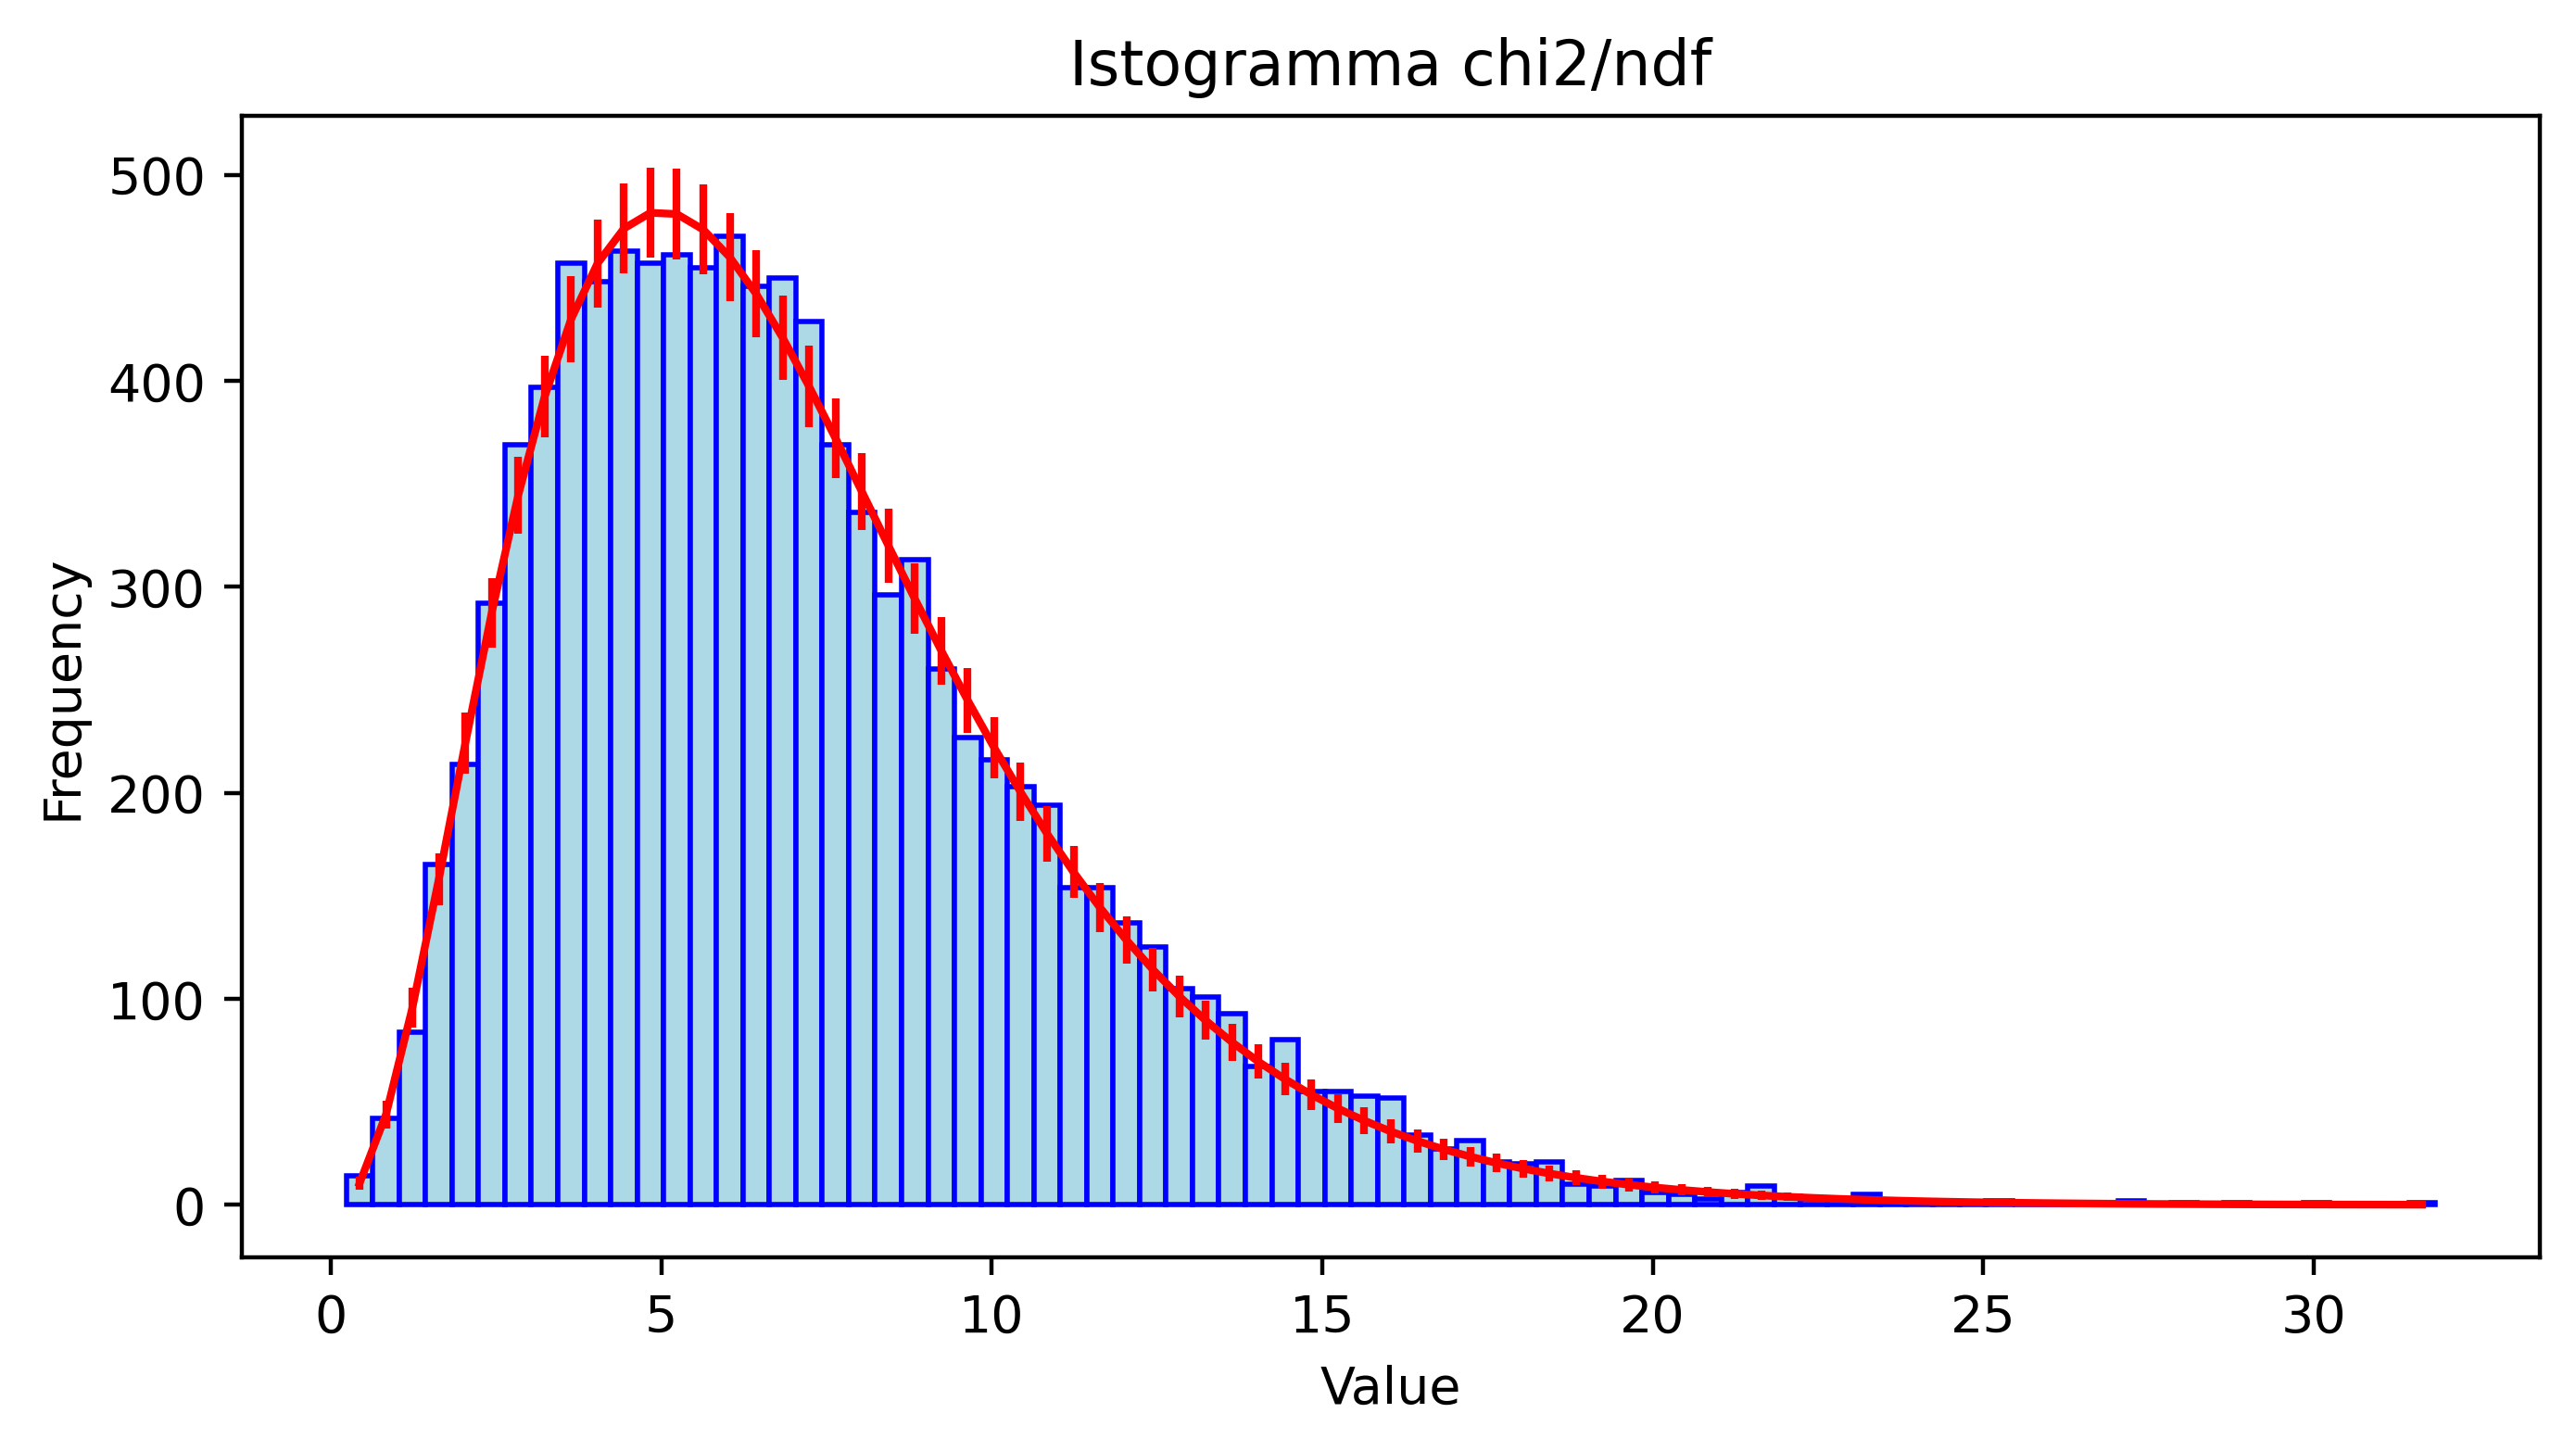

In [13]:
# Histogram chi2

ndf = 7
min_value = np.min(testResults[:,1])*ndf
max_value = np.max(testResults[:,1])*ndf
# min_value = np.min(testResults[:,1])
# max_value = np.max(testResults[:,1])
nbins = 80
interval = (max_value - min_value)/nbins


plt.figure(figsize=(8, 4), dpi=400)

# Chi2 Distribution
chi_n = lambda y : (np.pow(y, (ndf/2.0 - 1))*np.exp(-y/2.0))/(np.pow(2.0, ndf/2.0) * gamma(ndf/2.0))
binEdges = np.linspace(min_value, max_value, num=nbins)

xpoints = np.empty(shape = nbins - 1)
xpoints = (binEdges[1:] + binEdges[0:-1])/2

ypoints = chi_n(xpoints)*interval*num_points
y_err = np.sqrt(ypoints)
plt.errorbar(xpoints, ypoints, yerr = y_err, color = 'red')

# Create a histogram
dataHistogram = plt.hist(testResults[:,1]*ndf, bins=binEdges, color='lightblue', edgecolor='blue')

t_alpha = findCriticalZone(0.05, nbins - 1)

yexpected = np.empty(shape = (nbins - 1))
stdy = np.empty(shape = (nbins -1))
for i in range(nbins - 1):
    yexpected[i] = ypoints[i] + interval/2
    stdy[i] = y_err[i] 

#print(dataHistogram)


# Label the axes
plt.xlabel('Value')
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Istogramma chi2/ndf')

# Display the plot

plt.show()
plt.close()

#### Test di Pearson sul calcolo del $\chi_n^2$

In [14]:
test = np.sum((dataHistogram[0] - yexpected)**2/(stdy**2))
print(f"t_campione = {test:.2f}")

alpha = 0.05
t_alpha = findCriticalZone(alpha, np.size(dataHistogram[0]))
print(f"t_alpha = {t_alpha:.2f}")

t_campione = 89.32
t_alpha = 100.75


### Istogramma del p-valore

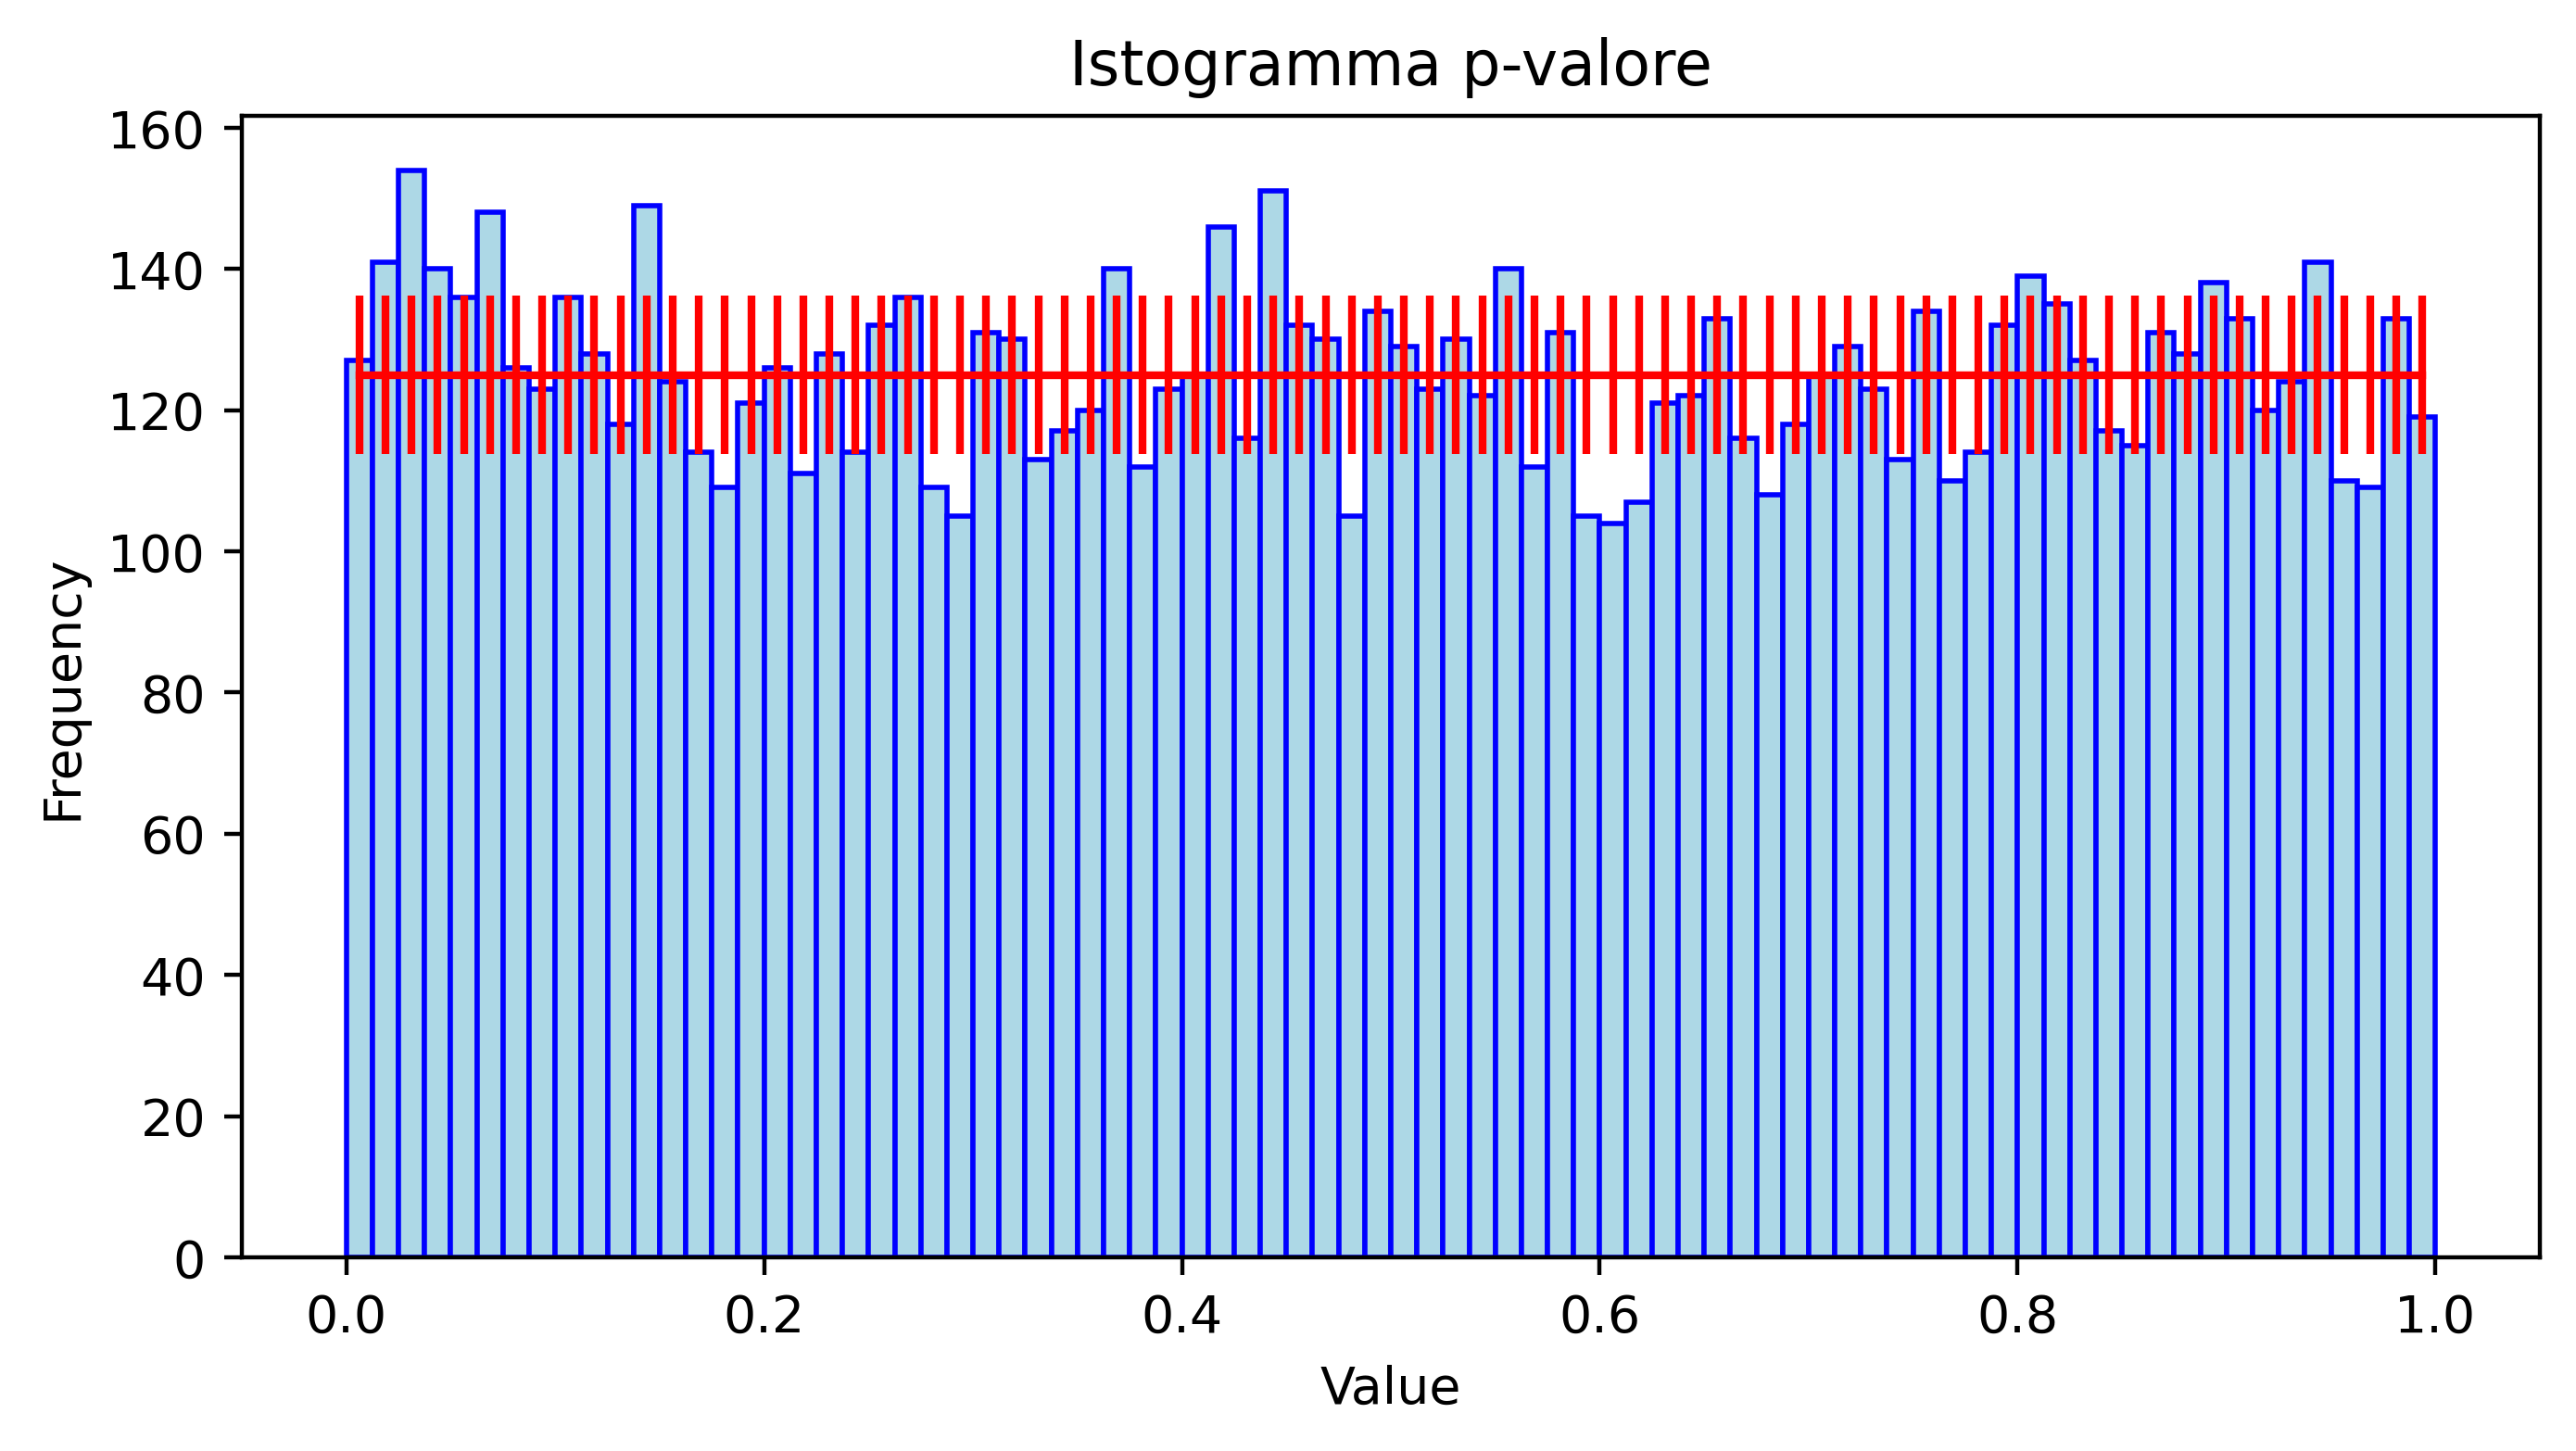

In [15]:
# Histogram p-value

min_value = np.min(testResults[:,2]) 
max_value = np.max(testResults[:,2])
nbins = 80
interval = (max_value - min_value)/nbins



# Create a histogram
plt.figure(figsize=(8, 4), dpi=400)
plt.hist(testResults[:,2], bins=80, color='lightblue', edgecolor='blue', density = False)

# Uniform Distribution
xpoints = np.linspace(min_value + interval/2, max_value - interval/2, num=nbins)
#ypoints = np.full(shape = np.shape(xpoints), fill_value=1)
ypoints = np.full(shape = np.shape(xpoints) , fill_value= interval*num_points)
y_err = np.sqrt(ypoints)
#plt.plot(xpoints, ypoints)
plt.errorbar(xpoints, ypoints, yerr = y_err, color = 'red')

# Label the axes
plt.xlabel('Value')
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Istogramma p-valore')

# Display the plot

plt.show()
plt.close()


In [16]:
n = 2
chi_n = lambda y : (np.pow(y, (n/2.0 - 1))*np.exp(-y/2.0))/(np.pow(2.0, n/2.0) * gamma(n/2.0))
print(trapezoid(chi_n(np.linspace(start=0, stop=1)), np.linspace(start=0, stop=1)))


0.3934727543913637
